In [ ]:
# the required imports
import numpy as np
import pandas as pd
# from linear_aproximation import Model
# from environment import network
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# additional import for the Neural Network
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras import optimizers
import tensorflow as tf

# for statistical plots
import seaborn as sns

In [3]:
# loading the original dataset
path = '/home/mawongh/ws/datasets/'
dataset = pd.read_pickle(path + 'full_dataset.pickle')

# this section:
# 1) add the stateid columns to filter the unique states later
# 2) normalizes the state vectors

# will convert to state ids
def state2stateid(s):
    return ''.join(str for str in s.astype(str).tolist())

state_id = [state2stateid(s) for s in dataset.state.tolist()]

# normalize the states
S_woScale = dataset.state.tolist()
Snext_woScale = dataset.s_next.tolist()
scaler = StandardScaler()
scaler.mean_ = np.loadtxt('s_raw_mean_.csv', delimiter=',')
scaler.scale_ = np.loadtxt('s_raw_scale_.csv', delimiter=',')
# scaler.fit(S_woScale)

S = scaler.transform(S_woScale)
Snext = scaler.transform(Snext_woScale)

dataset['state_norm'] = S.tolist()
dataset['s_next_norm'] = Snext.tolist()
dataset['state_id'] = state_id

# creates a new dataframe with the unique states
unique_states_df = dataset.groupby('state_id').first().reset_index()


In [5]:
# load the model from file
# modelfilename = 'MDP_model6.h5'
policyfilename = 'DQN_50k_policy.csv'
modelfilename = 'dqn_50k_model.h5'
model = load_model(path + modelfilename)

/home/mawongh/anaconda3/envs/rl/lib/python3.6/site-packages/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
# this estimate the greedy policy for each state in the sample
rhat = [np.argmax(model.predict(np.array(s).reshape(1,-1))[0])
        for s in unique_states_df.state_norm.tolist()]


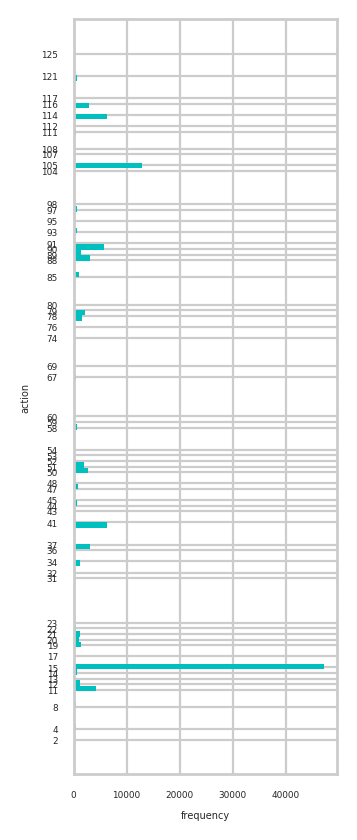

In [18]:
# creates a barplot showing the action distribution
ticks = np.unique(rhat)
# plt.figure(figsize = (6,1), dpi = 200)
# plt.hist(rhat, bins=126)
# plt.xticks(ticks)
# plt.show()
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=0.4)
plt.figure(figsize = (1.7,5), dpi = 200)
sns.distplot(rhat, bins=126, hist=True, kde=False, axlabel='action', vertical=True,
            hist_kws={"linewidth": 2,
                      "alpha": 1, "color": "c"})
plt.yticks(ticks)
plt.xlabel('frequency')
plt.show()


# save the policy sample file
np.savetxt(path + policyfilename, rhat, delimiter=',')

In [19]:
# processing the data for a heatmap of the value function
Rhat = [model.predict(np.array(s).reshape(1,-1))[0]
        for s in unique_states_df.state_norm.tolist()]
data_flat = np.array(Rhat).flatten()
data_mean = np.mean(data_flat)
data_stdev = np.std(data_flat)

#scaled the value function for comparison purposes
Rhat_scaled = [(x - data_mean) / data_stdev for x in Rhat]


# and storing it in a dataframe
data = pd.DataFrame(data = np.array(Rhat_scaled),columns = np.arange(126).astype(str))

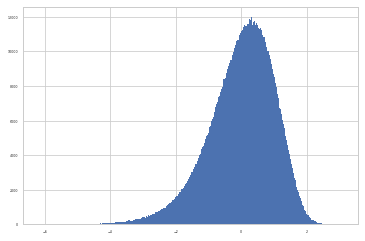

In [20]:
plt.hist(np.array(Rhat_scaled).flatten(), bins = 5000)
plt.show()

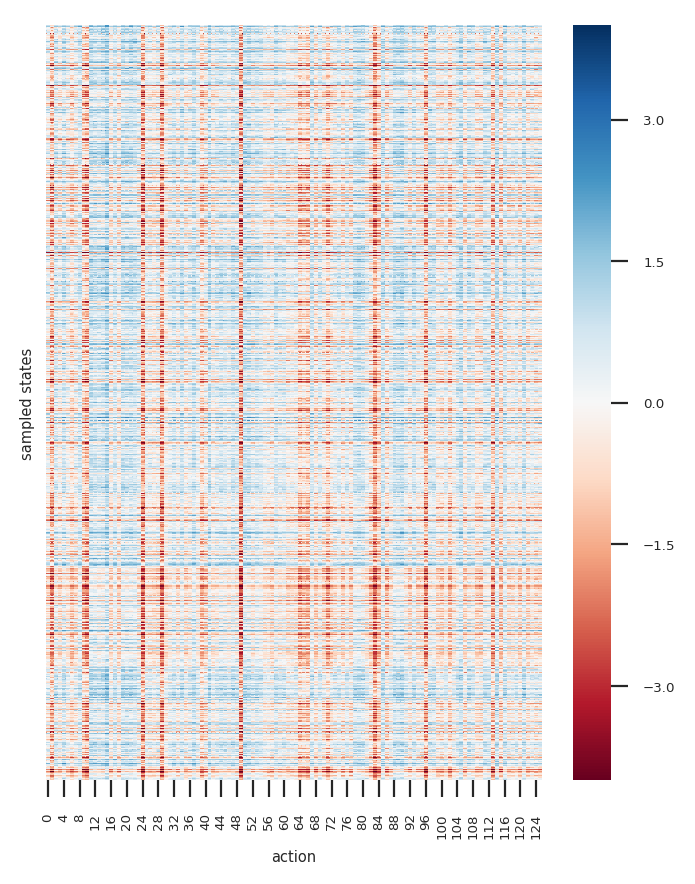

In [21]:
# displaying the heatmap
plt.figure(figsize=(4,5), dpi = 200)
sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=0.6)
# sns.axes_style({'ytick.color': '.5'})
# sns.heatmap(data = data, cmap = 'RdBu', vmin=-10, vmax = +5, center = -4, yticklabels=False)
sns.heatmap(data = data, cmap = 'RdBu', vmin = -4, vmax = +4, yticklabels=False)

plt.xlabel('action')
plt.ylabel('sampled states')
plt.show()

In [22]:
len(rhat)

118670

In [24]:
np.savetxt(path + policyfilename, rhat, delimiter=',')